# Lesson 6: Pets Revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

# Data Augmentation

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
doc(get_transforms)

get_transforms [source] get_transforms ( do_flip : bool = True , flip_vert : bool = False , max_rotate : float = 10.0 , max_zoom : float = 1.1 , max_lighting : float = 0.2 , max_warp : float = 0.2 , p_affine : float = 0.75 , p_lighting : float = 0.75 , xtra_tfms : Optional [ Collection [ Transform ]]= None ) → Collection [ Transform ] 
 
 Utility func to easily create a list of flip, rotate, zoom , warp, lighting transforms. 
 Show in docs

In [6]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = get_data(224, bs, 'zeros')

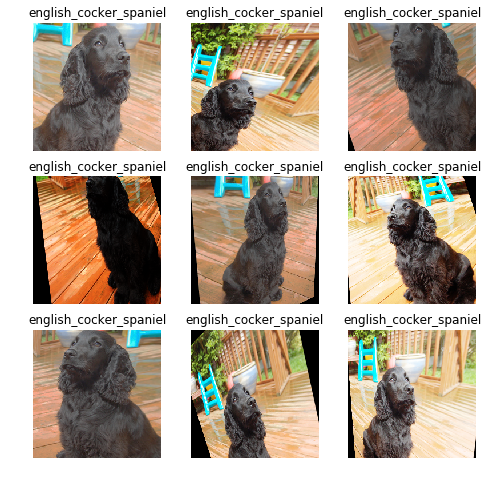

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [10]:
data = get_data(224,bs)

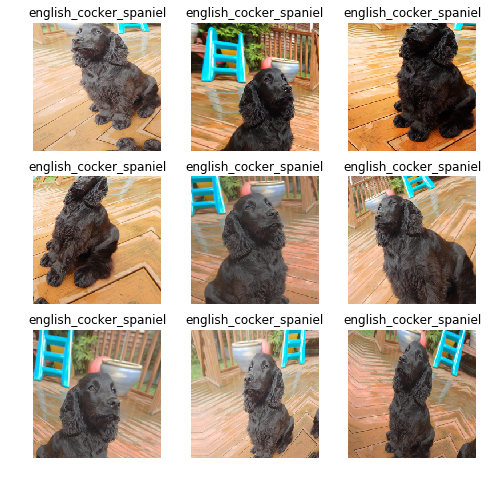

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

# Train a model

In [12]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [14]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.607088,1.460167,0.304466
2,1.571221,0.376579,0.104195
3,0.943451,0.287969,0.078484


In [15]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.712065,0.307167,0.070365
2,0.665014,0.300885,0.069012


In [16]:
data = get_data(352,bs)
learn.data = data

In [17]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.614484,0.291843,0.060893
2,0.592990,0.291227,0.062246


In [18]:
learn.save('352')

# Convolution Kernel

In [19]:
data = get_data(352,16)

In [20]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category japanese_chin

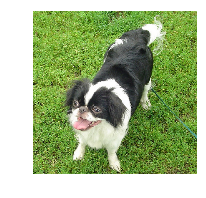

In [21]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [22]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [23]:
from fastai.callbacks.hooks import *

In [24]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [25]:
edge = F.conv2d(t[None], k)

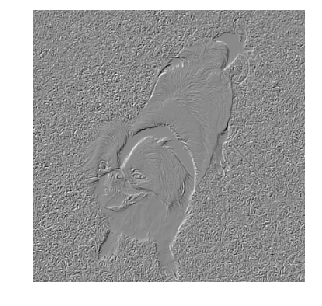

In [26]:
show_image(edge[0], figsize=(5,5));

# Heatmap

In [27]:
m = learn.model.eval();

In [28]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [29]:
from fastai.callbacks.hooks import *

In [30]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g


In [31]:
hook_a,hook_g = hooked_backward()

In [32]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [33]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [34]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

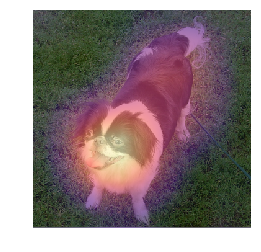

In [35]:
show_heatmap(avg_acts)

# Grad-CAM

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

Paper: https://arxiv.org/abs/1610.02391

In [36]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [37]:
mult = (acts*grad_chan[...,None,None]).mean(0)

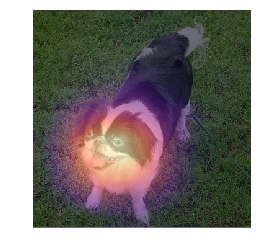

In [38]:
show_heatmap(mult)

Category american_bulldog

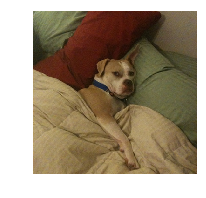

In [48]:
idx=201
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [49]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [50]:
hook_a,hook_g = hooked_backward()

In [51]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

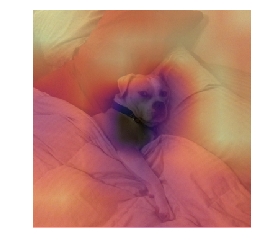

In [52]:
show_heatmap(mult)

The index below changes the category type and hence the features that the filters look at 

In [57]:
data.classes[1]

'Bengal'

In [59]:
hook_a,hook_g = hooked_backward(1)

In [60]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

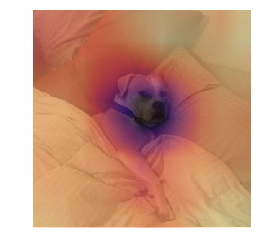

In [61]:
show_heatmap(mult)